<a href="https://colab.research.google.com/github/tb000330/BPA_Lab/blob/main/3_IF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime
import random

from tqdm import tqdm

from IPython.display import display
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# #1. 전처리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/학교/LAB/항법세트.csv')
df = df.drop(['사업장명', '검사구분', '자재코드', '자재명', '샘플번호', '검사키'], axis=1)

str_list = ['식별번호 일치여부', '부품 정상조립 여부', '보호피막 처리 누락 및 결함여부', 'S/W 버전 확인_PC전시화면', 'S/W 버전 확인_시험 프로그램', '초기고장배제 진동시험, 온도시험']

# 검사항목 pass/unpass drop
for s in str_list:
    df = df[df['검사항목']!=s]
df = df.reset_index(drop=True)

standard = df[['상한값', '하한값', '검사항목']][14:28].reset_index(drop=True)
standard['검사항목'] = ['pe_repeat','pe_head','pe_roll','pe_pitch', 'att_roll', 'att_pitch', 'att_head', 'set_0', 'set_90', 'set_180', 'set_270',  'weight', 'voltage', 'current']
standard = standard.fillna(0)

## 2. 검사항목 별 검사값 상관계수
df = df[['검사요청번호', '검사항목', '검사값']]
df_cor = df.pivot_table(index='검사요청번호', columns='검사항목', values='검사값')
df_cor.columns = ['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270']
df_cor

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
검사요청번호,,,,,,,,,,,,,,
OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800
OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610
OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750
OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227
OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OQ-20220705-00008,0.020,0.160,0.010,0.100,0.000,0.150,2.200,28.000,0.410,17.80,789.100,1238.900,755.400,1173.600
OQ-20220705-00009,0.020,0.250,0.000,0.110,0.000,0.170,2.100,28.000,0.210,17.70,291.700,1632.300,415.300,2320.300
OQ-20220718-00008,0.010,0.200,0.000,0.050,0.000,0.070,2.200,28.000,0.280,17.80,548.400,2322.200,549.600,1882.500


In [ ]:
df_cor = df_cor.reset_index()
df_cor['datetime'] = df_cor['검사요청번호'].str.slice(start=3, stop=11)
df_cor['datetime'] = pd.to_datetime(df_cor['datetime'], format='%Y%m%d')
df_cor

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
0,OQ-20201006-00022,0.016,0.237,0.044,0.096,0.059,0.114,2.180,28.007,0.286,17.66,271.300,700.200,586.500,877.800,2020-10-06
1,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.730,904.770,182.040,409.610,2020-10-29
2,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.370,1034.720,250.470,934.750,2020-10-29
3,OQ-20201112-00005,0.018,0.423,0.039,0.144,0.056,0.200,2.197,28.011,0.193,17.68,365.491,1388.559,444.647,1093.227,2020-11-12
4,OQ-20201119-00011,0.019,0.202,0.046,0.090,0.063,0.114,2.198,28.006,0.385,17.71,430.241,1169.491,399.156,1798.777,2020-11-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,OQ-20220705-00008,0.020,0.160,0.010,0.100,0.000,0.150,2.200,28.000,0.410,17.80,789.100,1238.900,755.400,1173.600,2022-07-05
77,OQ-20220705-00009,0.020,0.250,0.000,0.110,0.000,0.170,2.100,28.000,0.210,17.70,291.700,1632.300,415.300,2320.300,2022-07-05
78,OQ-20220718-00008,0.010,0.200,0.000,0.050,0.000,0.070,2.200,28.000,0.280,17.80,548.400,2322.200,549.600,1882.500,2022-07-18
79,OQ-20220718-00009,0.020,0.250,0.010,0.110,0.000,0.140,2.200,28.000,0.170,17.70,563.300,2288.600,512.600,1328.800,2022-07-18


## (1) padding 시간단위

In [ ]:
df_num = pd.DataFrame()

for date in df_cor['datetime'].unique():
  date_i = df_cor[df_cor['datetime']==date].reset_index(drop=True).reset_index()
  date_i['index'] = date_i['index'].astype(str)

  date_i['datetime_num'] = date_i['검사요청번호'].str.slice(start=3, stop=11) + '0' + date_i['index']
  df_num = df_num.append(date_i)

df_num = df_num.drop(['index'], axis=1).reset_index(drop=True)

df_num['datetime_num'] = pd.to_datetime(df_num['datetime_num'], format='%Y%m%d%H')
df_num = df_num[['검사요청번호'	,'pe_head'	,'att_head',	'pe_pitch',	'att_pitch'	,'pe_roll'	,'att_roll',	'current'	,'voltage'	,'pe_repeat',	'weight'	,'set_0'	,'set_180'	,'set_90',	'set_270',	'datetime_num','datetime']]

In [ ]:
df_num_pad = df_num.set_index('datetime_num').asfreq('H', method='pad')
df_num_pad[df_num_pad['datetime']=='2020-10-29']

,검사요청번호,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270,datetime
datetime_num,,,,,,,,,,,,,,,,
2020-10-29 00:00:00,OQ-20201029-00010,0.017,0.210,0.037,0.077,0.061,0.087,2.168,28.006,0.098,17.66,325.73,904.77,182.04,409.61,2020-10-29
2020-10-29 01:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 02:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 03:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-10-29 04:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-11 19:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-11-11 20:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29
2020-11-11 21:00:00,OQ-20201029-00011,0.021,0.265,0.043,0.141,0.064,0.200,2.178,28.007,0.275,17.68,333.37,1034.72,250.47,934.75,2020-10-29


## (2) 중복 datetime 다른 날짜로 분리

In [ ]:
# df_dup = df_cor.copy()
# df_dup['datetime'] = df_dup['datetime'].astype(str)
# dup_date = pd.DataFrame(df_dup.groupby(['datetime']).count())
# dup_date = dup_date[dup_date['검사요청번호']>1].reset_index()['datetime']
# dup_date

In [ ]:
# for date in dup_date.values:
#   date_index = df_dup[df_dup['datetime'] == date].index
#   for ind in range(len(date_index)):
#     if ind == 0:
#       pass
#     else:
#       dup_index = date_index[ind]
#       df_dup['datetime'][dup_index] = str(pd.to_datetime(date)+pd.DateOffset(days=ind))[:10]

# # 중복날짜 없는 지 확인
# (df_dup.groupby('datetime')['datetime'].count() > 1).unique()

In [ ]:
# df_dup['datetime'] = pd.to_datetime(df_dup['datetime'])
# df_dup

In [ ]:
# group1 = df_dup[['pe_repeat','att_head', 'datetime']]
# group2 = df_dup[['pe_head','pe_pitch','pe_roll', 'datetime']]
# group3 = df_dup[['att_pitch', 'att_roll', 'datetime']]
# group4 = df_dup[['set_0','set_90', 'datetime']]
# group5 = df_dup[['set_180', 'set_270', 'datetime']]
# group6 = df_dup[['current', 'datetime']]
# group7 = df_dup[['voltage', 'datetime']]
# group8 = df_dup[['weight', 'datetime']]

## (3) 상관관계

In [ ]:
df_num.corr(method='pearson')

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,-0.134285,0.038843,-0.036506,-0.017810,-0.034870,-0.059390,-0.128709,-0.061265,0.046910,0.056097,0.010547,0.112893,-0.120901
att_head,-0.134285,1.000000,0.068467,0.414388,0.104822,0.345653,0.086073,0.085250,0.066906,-0.171648,-0.061532,0.157021,0.167591,0.029178
pe_pitch,0.038843,0.068467,1.000000,0.013995,0.968736,-0.078624,0.237847,0.267870,-0.006799,-0.457198,-0.116934,0.163562,-0.077100,0.121748
att_pitch,-0.036506,0.414388,0.013995,1.000000,0.002308,0.960810,-0.089238,0.039908,0.114537,-0.182366,-0.123451,-0.026061,0.047226,0.006031
pe_roll,-0.017810,0.104822,0.968736,0.002308,1.000000,-0.103833,0.218505,0.320142,-0.029204,-0.425309,-0.126235,0.151931,-0.081699,0.089636
att_roll,-0.034870,0.345653,-0.078624,0.960810,-0.103833,1.000000,-0.081819,-0.032482,0.078933,-0.162815,-0.121437,-0.040674,0.061060,0.016418
current,-0.059390,0.086073,0.237847,-0.089238,0.218505,-0.081819,1.000000,0.095071,0.061431,-0.320327,0.219890,0.246957,0.134822,0.212940
voltage,-0.128709,0.085250,0.267870,0.039908,0.320142,-0.032482,0.095071,1.000000,0.092878,0.026038,-0.142567,0.036721,-0.151064,0.046233
pe_repeat,-0.061265,0.066906,-0.006799,0.114537,-0.029204,0.078933,0.061431,0.092878,1.000000,-0.038647,0.164696,-0.014912,0.069561,0.033028
weight,0.046910,-0.171648,-0.457198,-0.182366,-0.425309,-0.162815,-0.320327,0.026038,-0.038647,1.000000,0.088328,-0.109533,-0.069946,-0.054024


# #2. Isolation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

## #(1) 단일 변수

In [ ]:
df_num = df_num.iloc[:,1:]

In [ ]:
def univar_isolation_forest(df,columns,ratio):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  IF_model = model.fit(data)
  # IF_model = model.fit(group)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['pred_y'] = model.predict(data)
  group_result['decision_function'] = model.decision_function(data)
  group_result['pred_y_score'] = model.score_samples(data)
  group_result['col'] = str(columns)

  return group_result

In [ ]:
isolation_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = univar_isolation_forest(df_num, col, .05)

  isolation_result = pd.concat([isolation_result,df_col], axis=0)

isolation_result.sort_values(by=['col','pred_y_score']).head(10)

,X,pred_y,decision_function,pred_y_score,col
datetime_num,,,,,
2021-09-13 00:00:00,0.030,-1,-0.074319,-0.723934,att_head
2021-01-26 00:00:00,0.500,-1,-0.063165,-0.712781,att_head
2020-11-23 00:00:00,0.484,-1,-0.024256,-0.673872,att_head
2020-11-23 02:00:00,0.052,-1,-0.004139,-0.653754,att_head
2021-11-23 02:00:00,0.060,1,0.000000,-0.649616,att_head
2021-05-26 01:00:00,0.460,1,0.002856,-0.646760,att_head
2021-10-29 01:00:00,0.440,1,0.039495,-0.610121,att_head
2022-05-23 01:00:00,0.410,1,0.050348,-0.599268,att_head
2021-07-13 00:00:00,0.100,1,0.053891,-0.595724,att_head


In [ ]:
isolation_result

,X,pred_y,pred_y_score,col
datetime_num,,,,
2020-10-06 00:00:00,0.016,1,-0.609061,pe_head
2020-10-29 00:00:00,0.017,1,-0.609868,pe_head
2020-10-29 01:00:00,0.021,-1,-0.644588,pe_head
2020-11-12 00:00:00,0.018,1,-0.540538,pe_head
2020-11-19 00:00:00,0.019,1,-0.536698,pe_head
...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,-0.419608,set_270
2022-07-05 02:00:00,2320.300,1,-0.584073,set_270
2022-07-18 00:00:00,1882.500,1,-0.478242,set_270


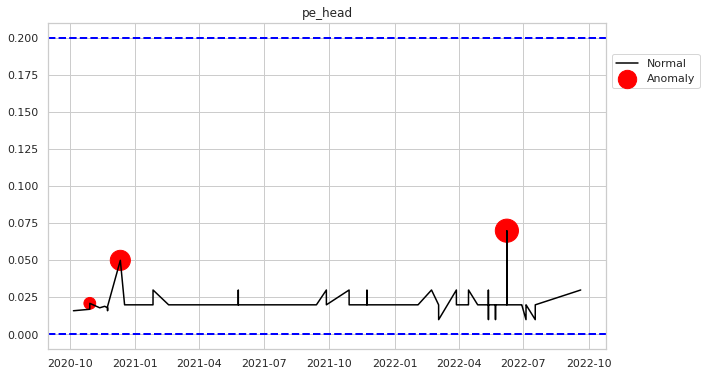

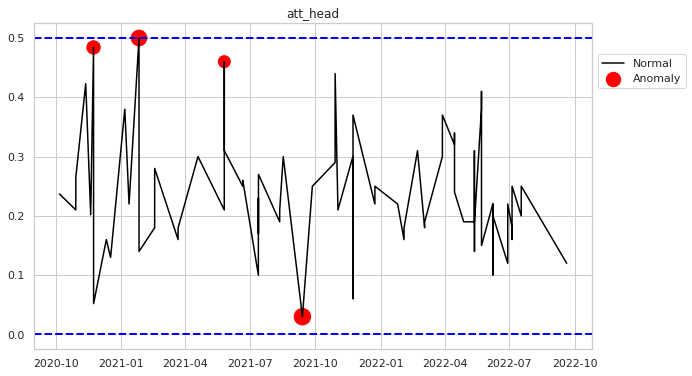

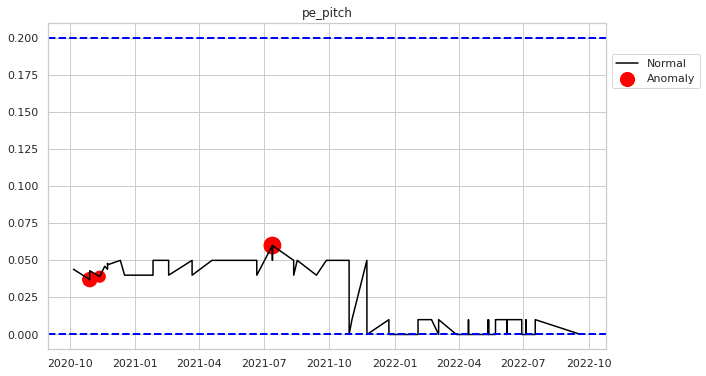

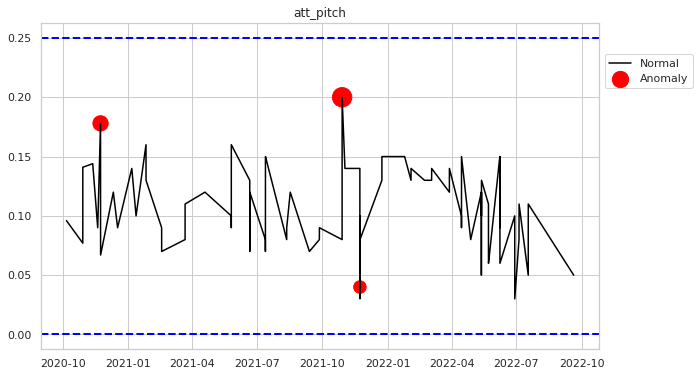

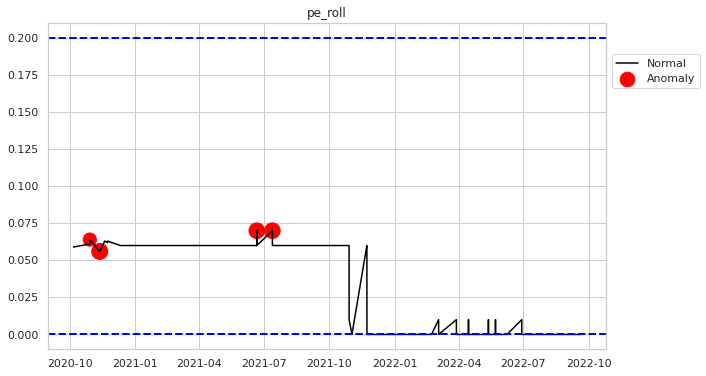

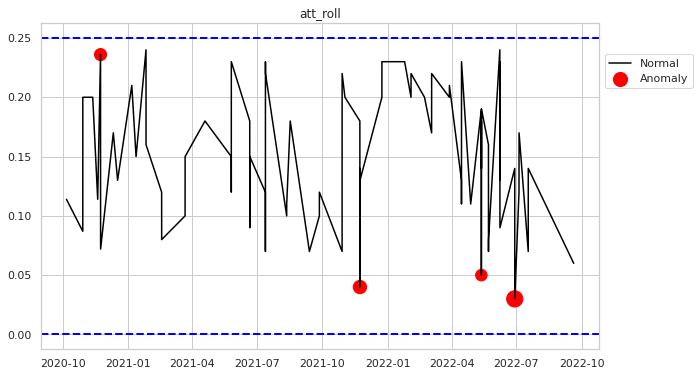

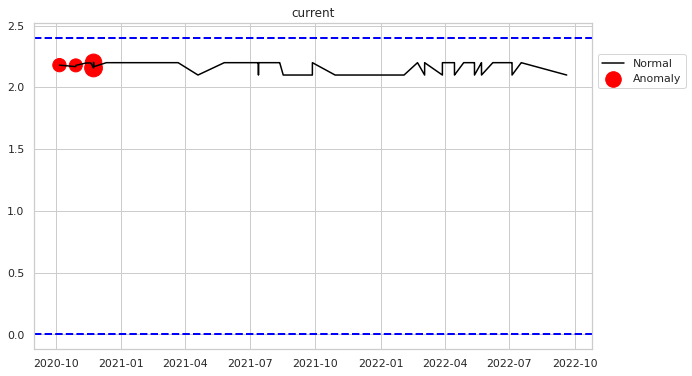

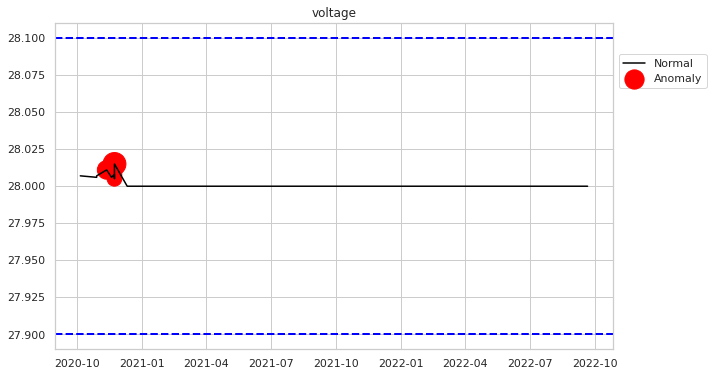

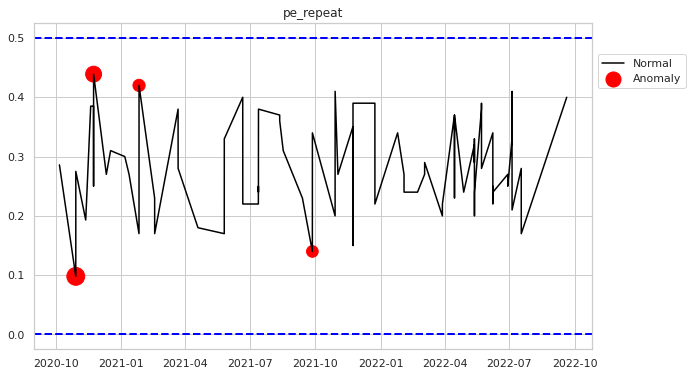

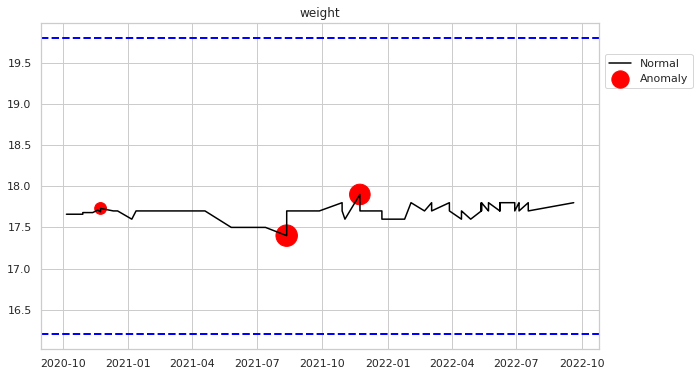

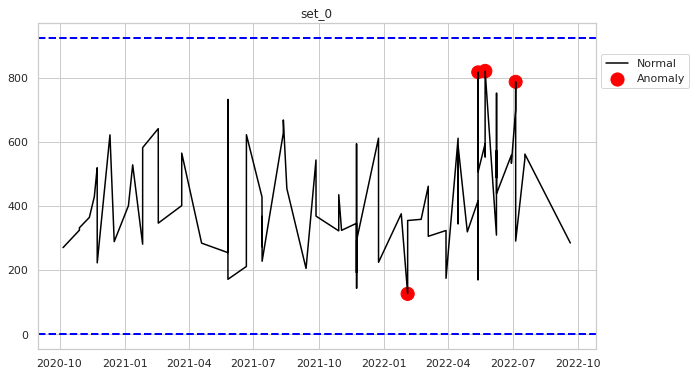

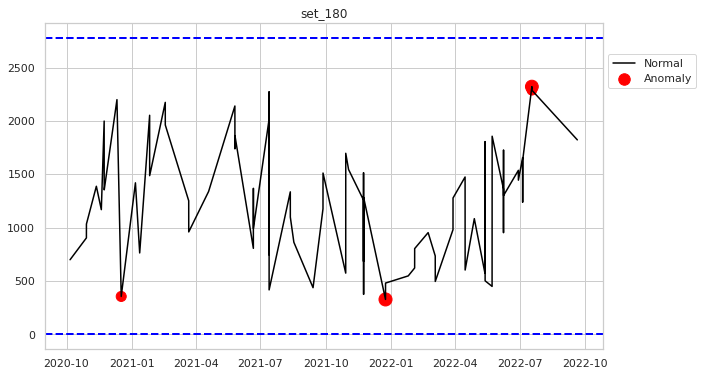

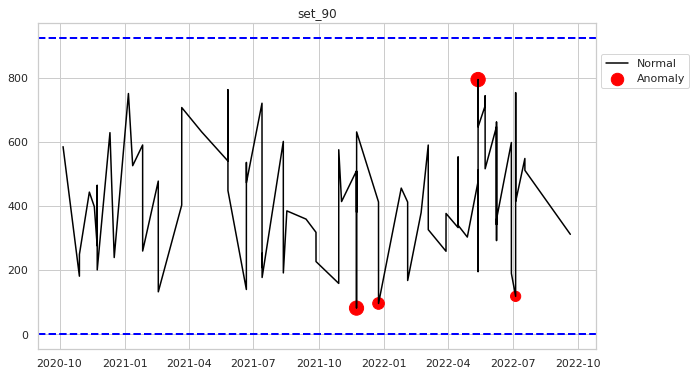

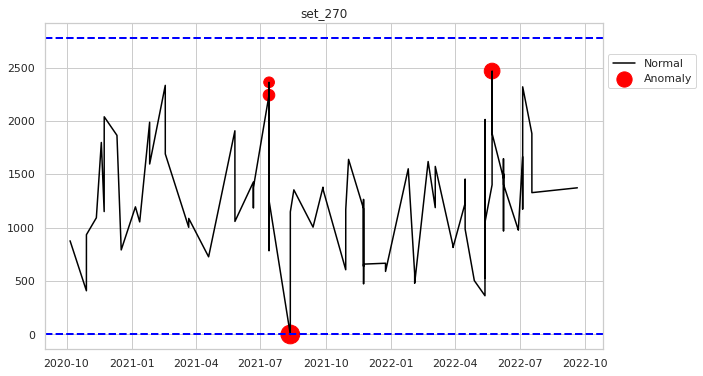

In [ ]:
# visualization
def IF_visualization(col_df, result_df):
  for col in col_df.columns[0:14]:
    fig, ax = plt.subplots(figsize=(10,6))
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['pred_y_score']
    s = [((abs(n*10)**(5))/80) for n in anomal_size]

    up_lne = standard.loc[standard['검사항목']==col, ['상한값']].values[0][0]
    down_lne = standard.loc[standard['검사항목']==col, ['하한값']].values[0][0]

    ax.plot(inspct.index, inspct['X'], color='black', label = 'Normal')
    ax.scatter(anomal_point.index, anomal_point['X'], s=s, color='red', label = 'Anomaly')

    plt.axhline(up_lne, color='blue', linestyle='--', linewidth=2)
    plt.axhline(down_lne, color='blue', linestyle='--', linewidth=2)

    plt.legend(loc=(1.01, 0.8))
    plt.title(str(col))
    plt.show()

IF_visualization(df_num, isolation_result)

## (2) 다변수

In [ ]:
def multivar_isolation_forest(df,ratio):
  multivar_result = pd.DataFrame()
  
  df_multi = df.loc[:,'pe_head':'set_270']
  df_multi['datetime_num'] = df['datetime_num']
  df_multi = df_multi.set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(df_multi.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  model.fit(data)

  multivar_result['scaled_X'] = data
  multivar_result['pred_y'] = model.predict(data)
  multivar_result['pred_y_score'] = model.score_samples(data)

  # visualization
  fig, ax = plt.subplots(figsize=(20,10))

  anomal_point = multivar_result.loc[multivar_result['pred_y'] == -1, ['scaled_X']] #anomaly
  ax.plot(multivar_result.index, multivar_result['scaled_X'], color='black', label = 'Normal')
  ax.scatter(anomal_point.index,anomal_point['scaled_X'], color='red', label = 'Anomaly')
  plt.legend(loc=(1.01, 0.8))
  # plt.title(str(columns))
  plt.show()
  
  return multivar_result

In [ ]:
# multivar_isolation_forest(df_num, 0.05)

## (3) 성능 평가

In [ ]:
def IF_stmltn(df,col,ratio,noise_num):
  result = pd.DataFrame()
  
  X = df[[col, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  ## 표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
  train_data = pd.DataFrame(np_scaled)

  ## 모델학습
  model = IsolationForest(contamination=outliers_fraction)
  trained_model = model.fit(train_data)

  ## 이상치 샘플
  X_values = list(X[col].values)
  up = standard[standard['검사항목']==col]['상한값'].values[0]
  down = standard[standard['검사항목']==col]['하한값'].values[0]

  for i in range(0, noise_num):
      sample = [round(random.uniform(down, up), 2)]
      X_values.extend(sample)

  # X_values = random.shuffle(X_values)
  np_scaled = scaler.fit_transform(np.array(X_values).reshape(-1, 1))
  test_data = pd.DataFrame(np_scaled)

  result['X'] = X_values
  result['pred_y'] = model.predict(test_data)
  result['pred_y_score'] = model.score_samples(test_data)
  result['col'] = str(col)

  return result

In [ ]:
test_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = IF_stmltn(df_num,col,0.05, 10)

  test_result = pd.concat([test_result,df_col], axis=0)

test_result.sort_values(by=['col','pred_y_score']).head(10)

,X,pred_y,pred_y_score,col
85,0.010,-1,-0.736680,att_head
33,0.030,-1,-0.693913,att_head
12,0.500,-1,-0.686531,att_head
5,0.484,-1,-0.662980,att_head
7,0.052,1,-0.629314,att_head
20,0.460,1,-0.624239,att_head
41,0.060,1,-0.616796,att_head
37,0.440,1,-0.606631,att_head
3,0.423,1,-0.600862,att_head
87,0.420,1,-0.600121,att_head


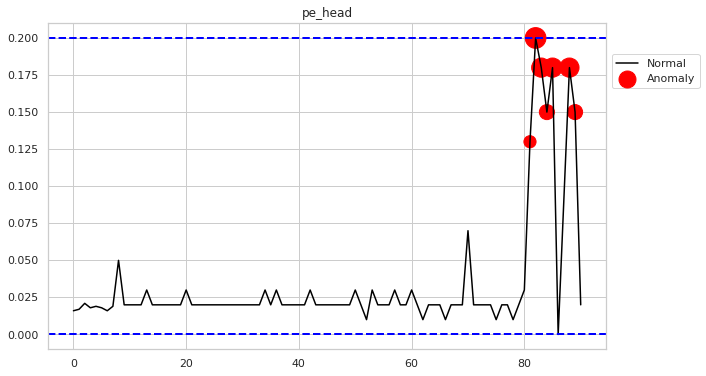

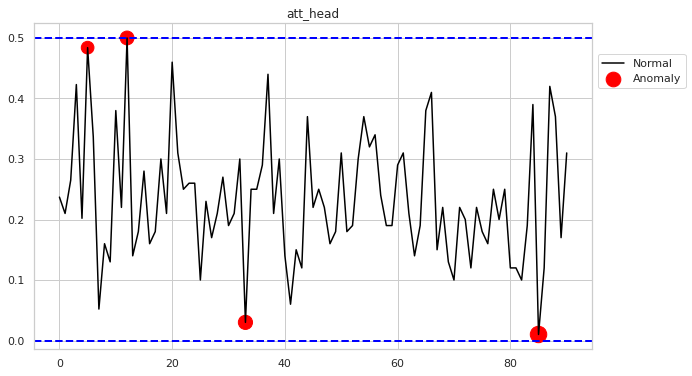

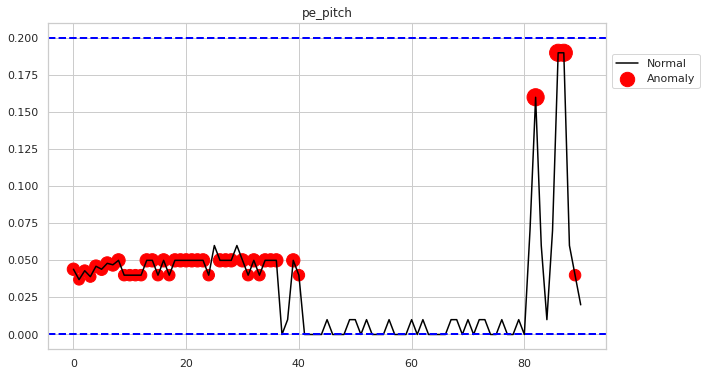

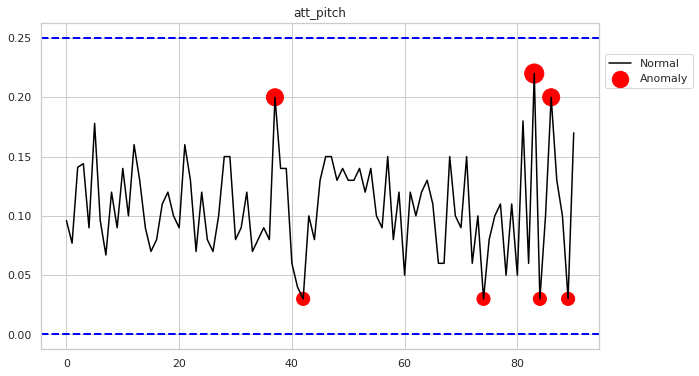

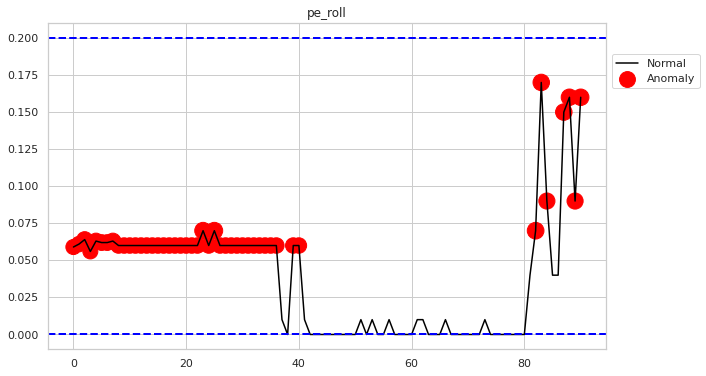

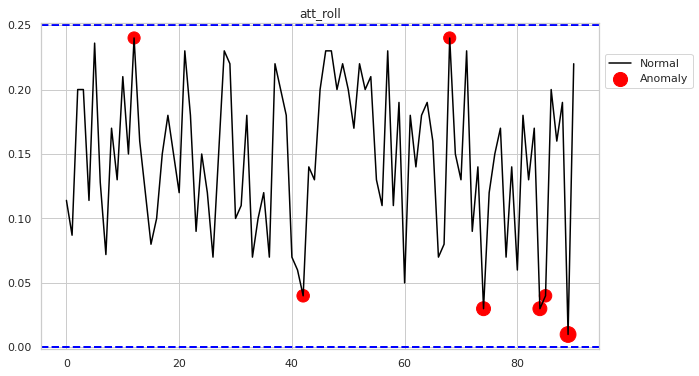

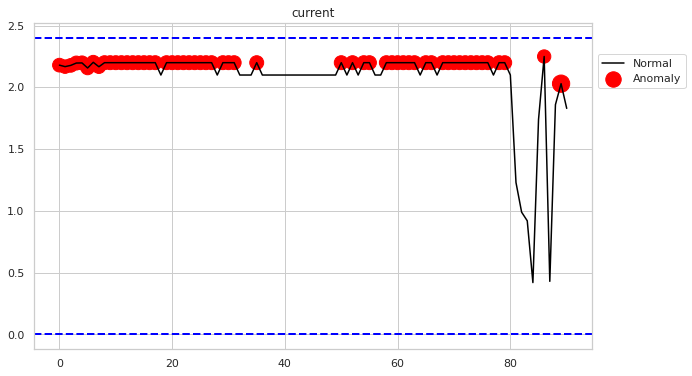

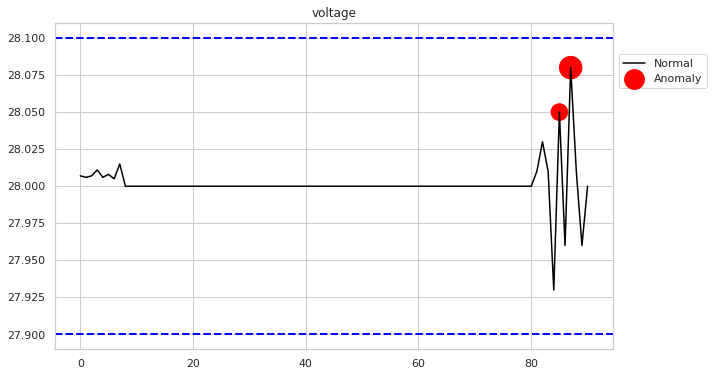

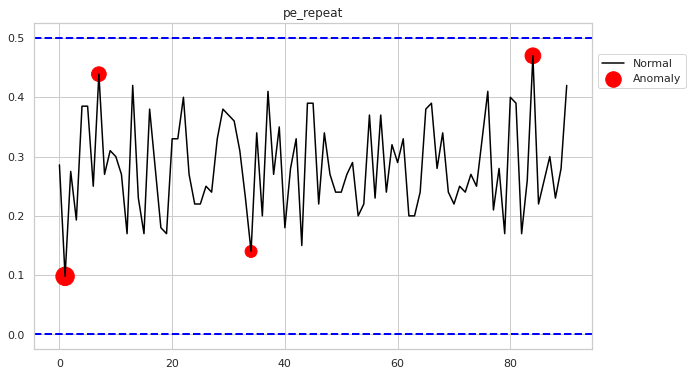

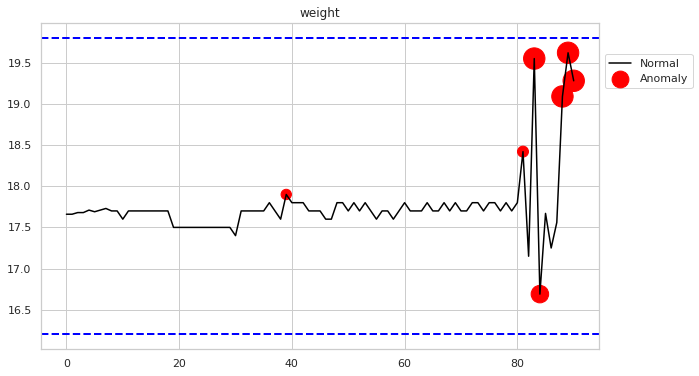

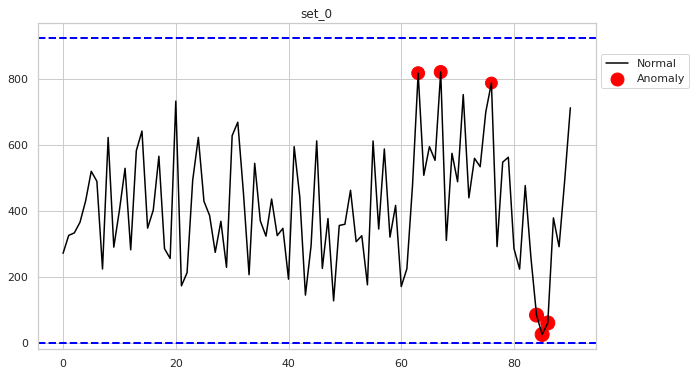

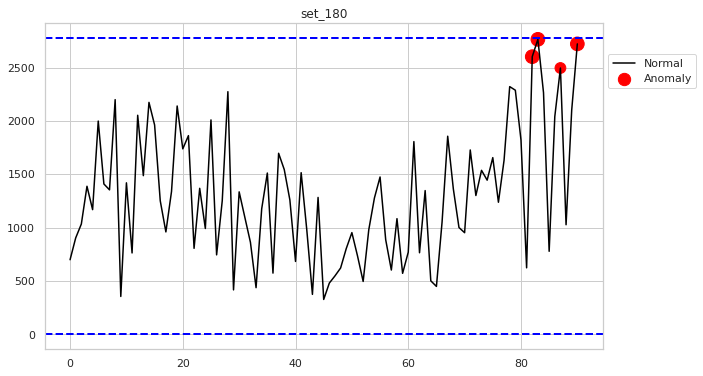

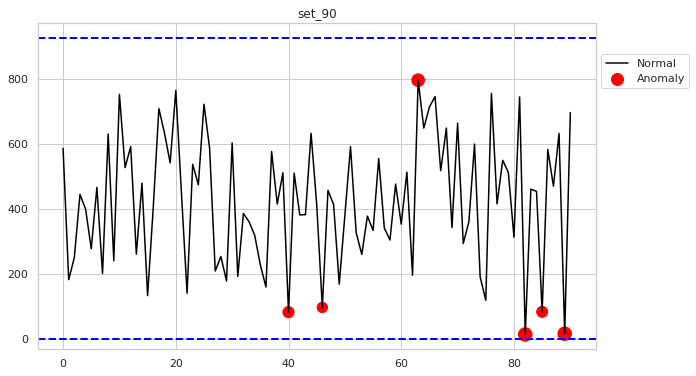

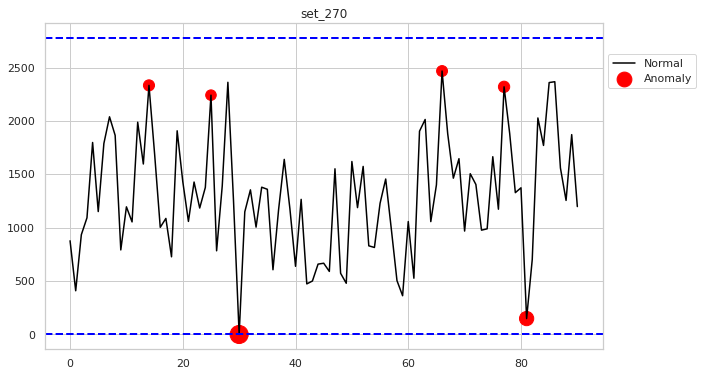

In [ ]:
## visualization
IF_visualization(df_num, test_result)

## (4) odds ratio

- 오즈(odds):  (사건 A가 일어날 확률) / (사건 A가 일어나지 않을 확률)

  $Odds = \frac{P}{1-P}$

In [ ]:
def odds_fn(P):
  return (P)/(1-P)

In [ ]:
isolation_result

,X,pred_y,pred_y_score,col
datetime_num,,,,
2020-10-06 00:00:00,0.016,1,-0.609061,pe_head
2020-10-29 00:00:00,0.017,1,-0.609868,pe_head
2020-10-29 01:00:00,0.021,-1,-0.644588,pe_head
2020-11-12 00:00:00,0.018,1,-0.540538,pe_head
2020-11-19 00:00:00,0.019,1,-0.536698,pe_head
...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,-0.419608,set_270
2022-07-05 02:00:00,2320.300,1,-0.584073,set_270
2022-07-18 00:00:00,1882.500,1,-0.478242,set_270


In [ ]:
## 이상치 개수(pred_y_score)

def odds_ratio_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['pred_y_score']

    ##odds
    risk_P = len(anomal_point)/len(inspct)
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_result(df_num, isolation_result)

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649
att_head,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
pe_pitch,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
att_pitch,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649
pe_roll,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
att_roll,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
current,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
voltage,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
pe_repeat,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
weight,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649


In [ ]:
## 이상치 정도(pred_y_score)

def odds_ratio_score_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별

    inspct_score = np.sum(np.abs(inspct['pred_y_score'].values))
    anomal_score = np.sum(np.abs(inspct.loc[inspct['pred_y']==-1]['pred_y_score'].values))

    ##odds
    risk_P = anomal_score/inspct_score
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_score_result(df_num, isolation_result) #칼럼:분자, 인덱스:분모 -> pe_head가 att_head보다 이상치가 발생할 확률

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,1.039921,0.997091,0.775572,1.061308,0.949472,1.121691,1.206478,1.009950,0.902992,0.975546,0.897549,0.944006,1.016831
att_head,0.961611,1.000000,0.958814,0.745798,1.020566,0.913023,1.078630,1.160162,0.971179,0.868327,0.938096,0.863093,0.907767,0.977795
pe_pitch,1.002918,1.042956,1.000000,0.777834,1.064405,0.952242,1.124963,1.209998,1.012897,0.905627,0.978392,0.900167,0.946761,1.019797
att_pitch,1.289372,1.340845,1.285621,1.000000,1.368421,1.224223,1.446276,1.555598,1.302201,1.164292,1.257842,1.157274,1.217175,1.311072
pe_roll,0.942233,0.979849,0.939492,0.730769,1.000000,0.894624,1.056894,1.136783,0.951609,0.850829,0.919192,0.845700,0.889474,0.958091
att_roll,1.053217,1.095263,1.050153,0.816845,1.117788,1.000000,1.181383,1.270682,1.063697,0.951046,1.027462,0.945313,0.994243,1.070943
current,0.891511,0.927102,0.888918,0.691431,0.946168,0.846465,1.000000,1.075588,0.900382,0.805028,0.869710,0.800175,0.841592,0.906516
voltage,0.828859,0.861948,0.826448,0.642840,0.879675,0.786979,0.929724,1.000000,0.837107,0.748453,0.808590,0.743941,0.782448,0.842809
pe_repeat,0.990148,1.029676,0.987267,0.767930,1.050852,0.940118,1.110640,1.194591,1.000000,0.894096,0.965935,0.888706,0.934706,1.006812
weight,1.107429,1.151640,1.104208,0.858891,1.175324,1.051473,1.242193,1.336089,1.118449,1.000000,1.080349,0.993972,1.045420,1.126068


## (5) 분산 및 잔차

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels as sm
import statsmodels.api as sm

In [ ]:
df_num['date2num'] = dates.date2num(df_num['datetime_num'].values)
df_num = df_num[['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270', 'date2num', 'datetime_num',	'datetime']]

In [ ]:
# dates.num2date(df_num['date2num'].values)

In [ ]:
def least_square_line(x,f):
    b = (np.mean(x)*np.mean(f) - np.mean(x*f))/(np.mean(x)*np.mean(x)-np.mean(x*x))
    a = np.mean(f)-np.mean(x)*b
    return a,b

In [ ]:
def resid_fn(df): 
  resid_rslt = pd.DataFrame()

  for col in df.columns[:-1]:
    x = df['date2num'].values
    f = df[col].values

    a, b = least_square_line(x,f)
    # print(f'y = {a:.2f}+{b:.2f}x')
    
    ## |최소자승법 y|-|실제값 y|
    resid_list = [abs(abs(a+b*xi)-abs(fi)) for xi, fi in zip(x,f)]
    resid_rslt[col] = resid_list
  
  return resid_rslt

ols_resid = resid_fn(df_num.loc[:,'pe_head':'date2num'])

In [ ]:
ols_resid

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
0,0.005095,0.025834,0.013535,0.018169,0.018585,0.037706,0.000010,0.003682,0.004091,0.042062,103.831906,607.985118,181.608214,402.654945
1,0.004114,0.051118,0.018526,0.036648,0.013732,0.064462,0.011091,0.002834,0.183937,0.037983,52.617647,397.925098,224.129805,869.333272
2,0.000114,0.003885,0.012523,0.027353,0.010727,0.048539,0.001089,0.003834,0.006937,0.057976,44.983473,267.965152,155.702120,344.190534
3,0.003126,0.162926,0.015304,0.030669,0.016995,0.048687,0.018469,0.007926,0.088953,0.055501,14.814054,89.205654,37.699270,184.796123
4,0.002131,0.057552,0.007692,0.023172,0.009127,0.037239,0.019749,0.002973,0.103039,0.084260,48.957242,128.191470,8.180692,521.213951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.001618,0.055322,0.008092,0.000267,0.001432,0.005054,0.045462,0.000892,0.127340,0.069106,324.900236,82.774531,315.110324,64.985429
77,0.001618,0.034681,0.001904,0.010268,0.001437,0.025054,0.054536,0.000892,0.072660,0.030902,172.505590,476.184476,24.991992,1081.717310
78,0.011628,0.014356,0.000776,0.049439,0.003040,0.074808,0.045980,0.000978,0.002675,0.066808,82.388469,1169.167640,108.590280,644.766257
79,0.001628,0.035647,0.009227,0.010562,0.003045,0.004808,0.045982,0.000978,0.112675,0.033199,97.282643,1135.577586,71.587965,91.068995


In [ ]:
## 각 변수별 전체 잔차 합
ols_resid.apply(lambda x : abs(x).sum())

pe_head          0.325392
att_head         5.960396
pe_pitch         0.883679
att_pitch        2.352715
pe_roll          0.967622
att_roll         3.865651
current          3.436587
voltage          0.117603
pe_repeat        5.206009
weight           6.006199
set_0        11207.001737
set_180      35473.388046
set_90       12607.477596
set_270      34099.770636
dtype: float64

In [ ]:
def resid_visualization(df, col, result_df): 
  fig, ax = plt.subplots(figsize=(10,6))

  x = df['date2num'].values
  f = df[col].values
  a, b = least_square_line(x,f)

  ax.plot_date(x, f, color='black',linestyle='--')
  ax.plot(x, a+b*x)

  inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
  anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
  ax.scatter(anomal_point.index, anomal_point['X'], s=100, c='red', label = 'Anomaly')

  plt.legend(loc=(1.01, 0.8))
  plt.title(col)

# resid_visualization(df_num, 'pe_head', isolation_result)

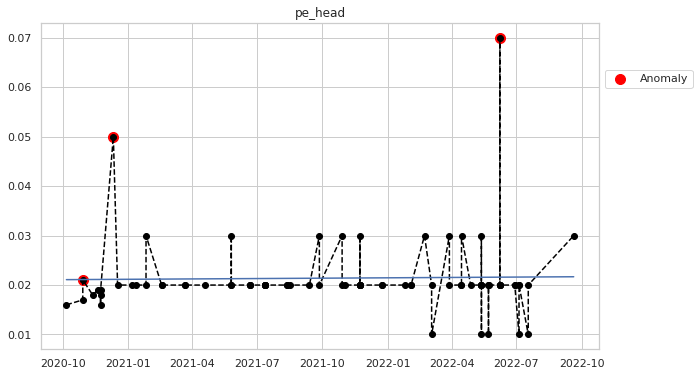

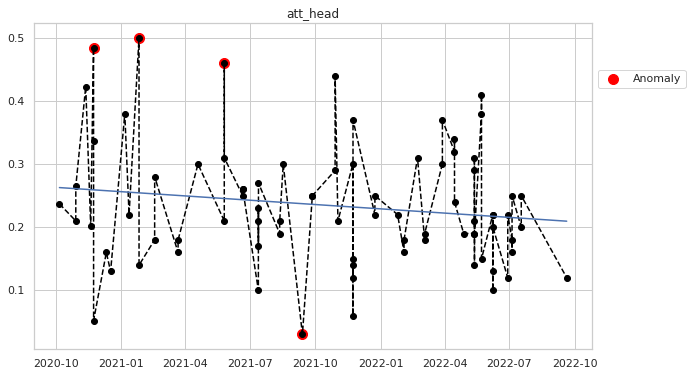

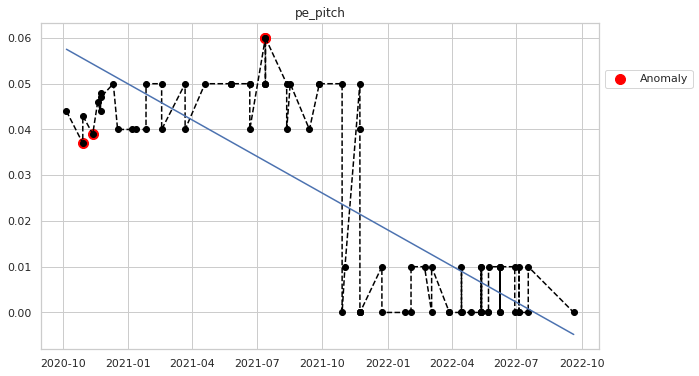

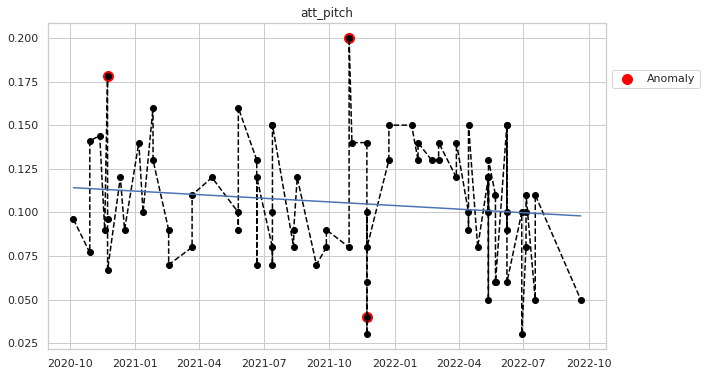

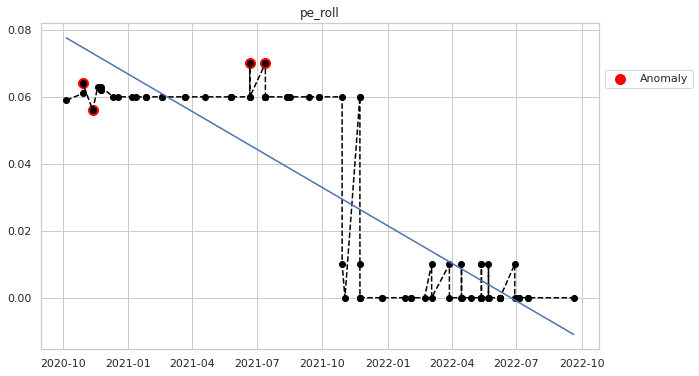

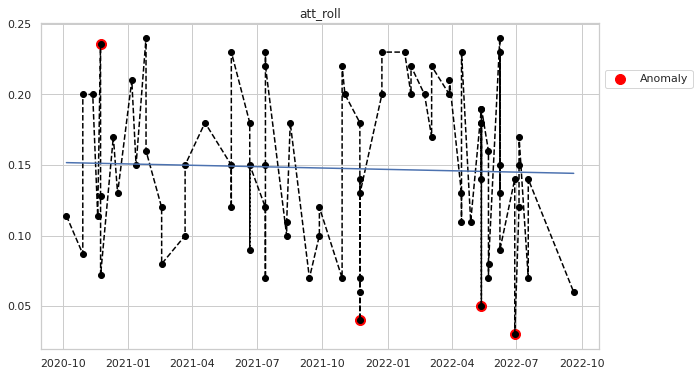

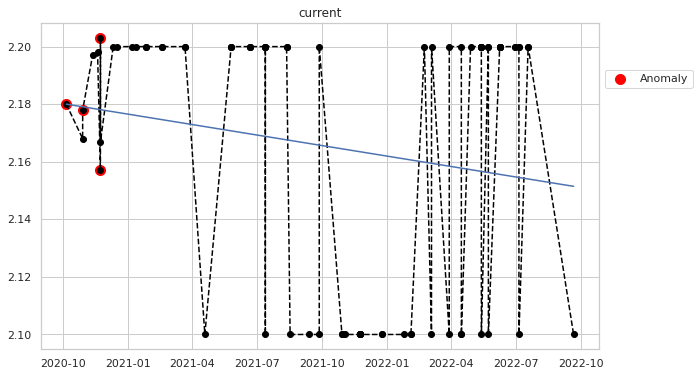

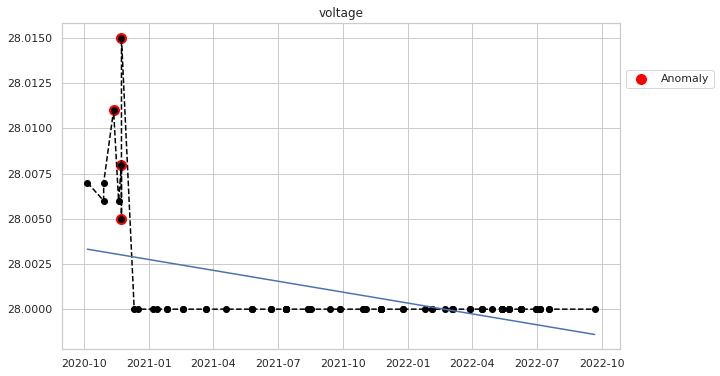

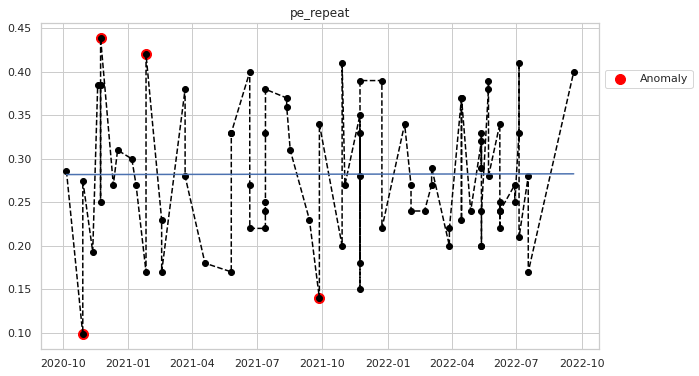

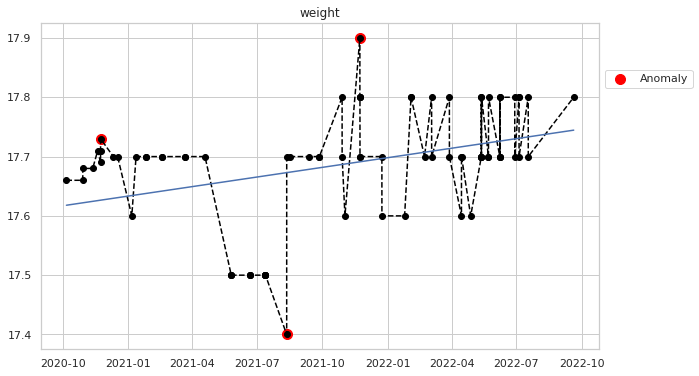

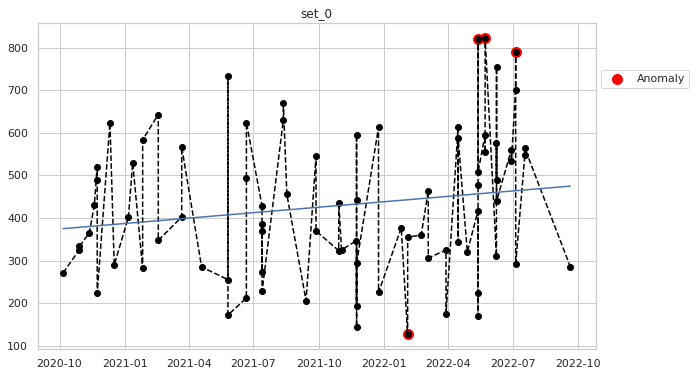

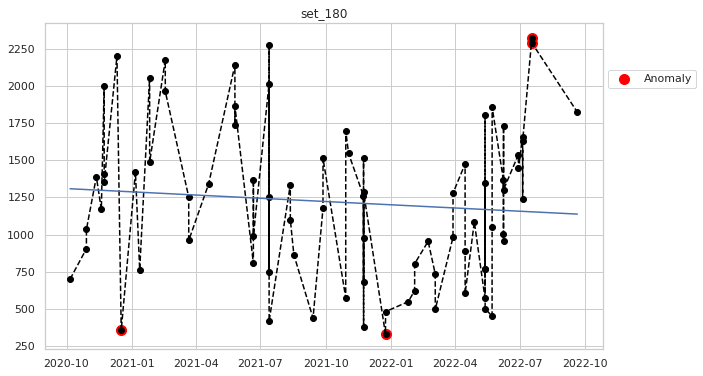

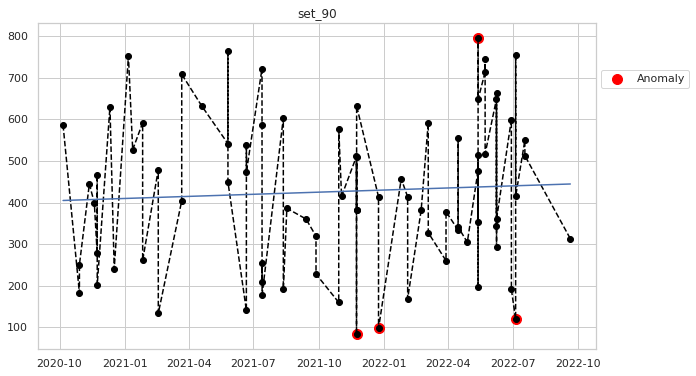

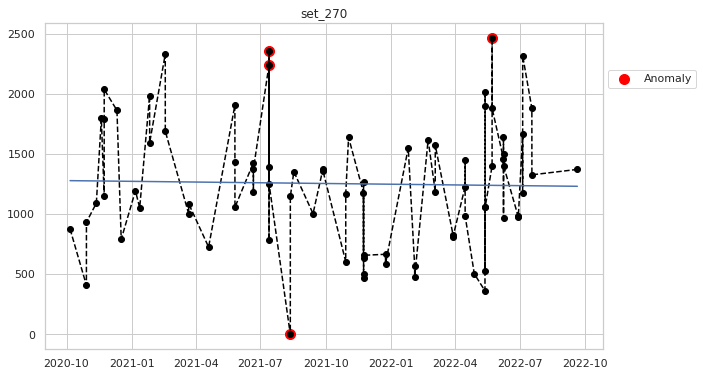

In [ ]:
for col in df_num.loc[:,'pe_head':'set_270'].columns:
  resid_visualization(df_num.loc[:,'pe_head':'date2num'], col, isolation_result)

## (6) 이상치가 기준에 가까운 정도

In [ ]:
def whole_standard_distance(df, stndrd):
  result = pd.DataFrame()

  for col in df['col'].unique():
    dstnc_list=[]

    for i in range(len(df[df['col']==col])):
      col_X = df[df['col']==col]['X'].values[i]

      up = stndrd[stndrd['검사항목']==col]['상한값'].values[0]
      low = stndrd[stndrd['검사항목']==col]['하한값'].values[0]

      if low == 0: #상기준만
        dstnc = up - col_X
      else: #상하 기준
        mu = col_X.mean()
        if col_X >= mu:
          dstnc = up - col_X
        else:
          dstnc = col_X - low
      
      dstnc_list.append(abs(dstnc))

    result[col] = dstnc_list

  return result

whl_stndrd_dstnc = whole_standard_distance(isolation_result, standard)
whl_stndrd_dstnc

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
0,0.184,0.263,0.156,0.154,0.141,0.136,0.220,0.093,0.214,2.14,654.700,2077.800,339.500,1900.200
1,0.183,0.290,0.163,0.173,0.139,0.163,0.232,0.094,0.402,2.14,600.270,1873.230,743.960,2368.390
2,0.179,0.235,0.157,0.109,0.136,0.050,0.222,0.093,0.225,2.12,592.630,1743.280,675.530,1843.250
3,0.182,0.077,0.161,0.106,0.144,0.050,0.203,0.089,0.307,2.12,560.509,1389.441,481.353,1684.773
4,0.181,0.298,0.154,0.160,0.137,0.136,0.202,0.094,0.115,2.09,495.759,1608.509,526.844,979.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.180,0.340,0.190,0.150,0.200,0.100,0.200,0.100,0.090,2.00,136.900,1539.100,170.600,1604.400
77,0.180,0.250,0.200,0.140,0.200,0.080,0.300,0.100,0.290,2.10,634.300,1145.700,510.700,457.700
78,0.190,0.300,0.200,0.200,0.200,0.180,0.200,0.100,0.220,2.00,377.600,455.800,376.400,895.500
79,0.180,0.250,0.190,0.140,0.200,0.110,0.200,0.100,0.330,2.10,362.700,489.400,413.400,1449.200


In [ ]:
## 확인
# df_num.loc[:,'pe_head':'set_270'] + whl_stndrd_dstnc

In [ ]:
def abnrml_standard_distance(df, stndrd):
  result_abn = pd.DataFrame()
  dstnc_abnrml_list=[]
  col_list=[]
  idx_list=[]

  for col in df['col'].unique():
    mu = np.mean(df[df['col']==col]['X'].values)
    col_X_abnrml = df[(df['col']==col)&(df['pred_y']==-1)]['X'].values
    
    abnrml_index = df[(df['col']==col)&(df['pred_y']==-1)]['X'].index
    idx_list.extend(abnrml_index)

    up = stndrd[stndrd['검사항목']==col]['상한값'].values[0]
    low = stndrd[stndrd['검사항목']==col]['하한값'].values[0]

    for i in range(len(col_X_abnrml)):
      abnrml = col_X_abnrml[i]
      if low == 0:
        dstnc_abnrml = up - abnrml
      else:
        if abnrml >= mu:
          dstnc_abnrml = up - abnrml
        else:
          dstnc_abnrml = abnrml - low
      
      dstnc_abnrml_list.append(abs(dstnc_abnrml))
      col_list.append(col)

  result_abn['abnrml_dstnc'] = dstnc_abnrml_list
  result_abn['col'] = col_list
  result_abn.index = idx_list

  return result_abn

abnrml_standard_distance(isolation_result, standard)

,abnrml_dstnc,col
2020-10-29 01:00:00,0.179,pe_head
2020-12-11 00:00:00,0.150,pe_head
2022-06-08 02:00:00,0.130,pe_head
2020-11-23 00:00:00,0.016,att_head
2021-01-26 00:00:00,0.000,att_head
...,...,...
2022-07-05 00:00:00,807.000,set_90
2021-07-13 00:00:00,535.700,set_270
2021-07-13 03:00:00,415.300,set_270
2021-08-12 00:00:00,2778.000,set_270


## (7) 응용 모델

### smoothing tool

In [ ]:
def moving_avarage_smoothing(X,k): # k=window size
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.median(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

def exponential_smoothing(X,a):
	S = np.zeros(X.shape[0])
	S[0] = X[0]
	for t in range(1,X.shape[0]):
		S[t] = a * X[t-1] + (1- a) * S[t-1]
	return S

Text(0.5, 1.0, 'pe_head (savgol_filter)')

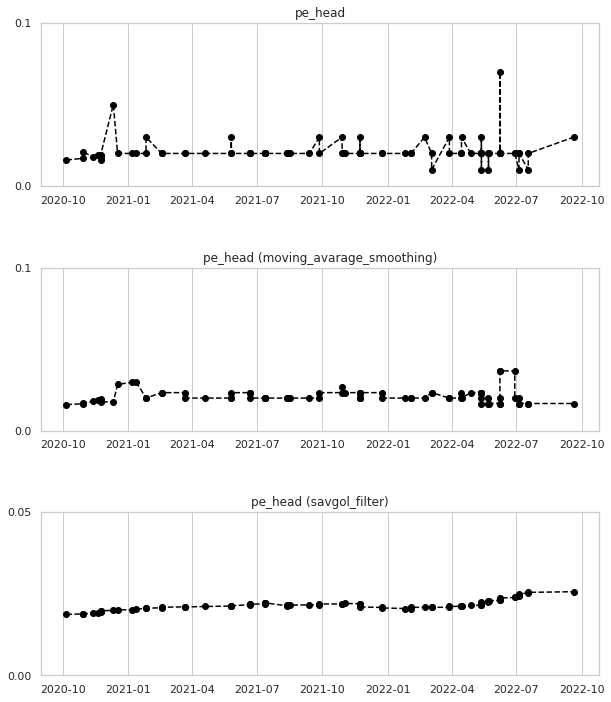

In [ ]:
fig, ax = plt.subplots(figsize=(10,12), nrows=3)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = moving_avarage_smoothing(df_num['pe_head'], 3)
f3 = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="constant", cval=df_num['pe_head'].mean())
f3 = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="nearest")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.1])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.1])
ax[1].set_title("pe_head (moving_avarage_smoothing)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.05])
ax[2].set_title("pe_head (savgol_filter)")

Text(0.5, 1.0, 'pe_head (wrap)')

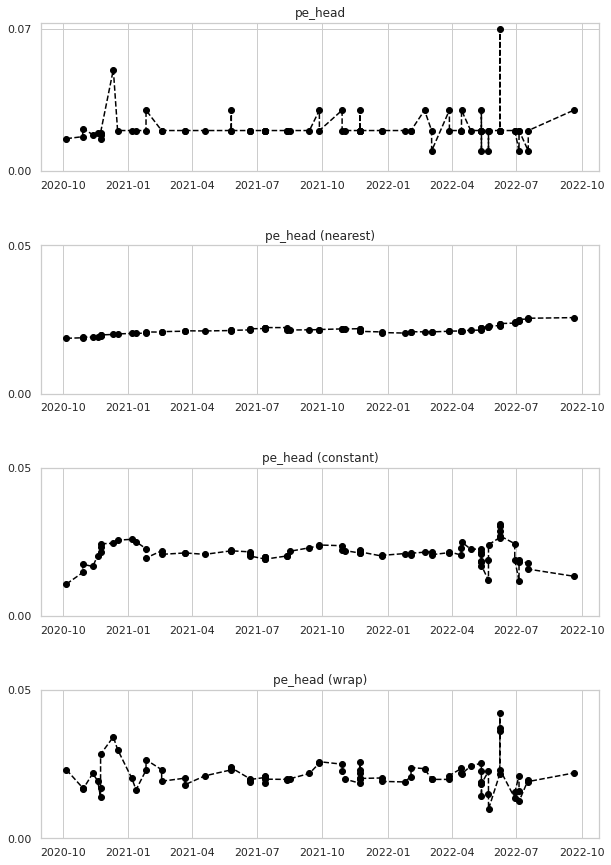

In [ ]:
fig, ax = plt.subplots(figsize=(10,15), nrows=4)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = signal.savgol_filter(df_num['pe_head'], window_length=79, polyorder=3, mode="nearest")
f3 = signal.savgol_filter(df_num['pe_head'], window_length=11, polyorder=3, mode="constant", cval=0)
f4 = signal.savgol_filter(df_num['pe_head'], window_length=23, polyorder=15, mode="wrap")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.07])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.05])
ax[1].set_title("pe_head (nearest)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.05])
ax[2].set_title("pe_head (constant)")

ax[3].plot_date(x, f4, color='black',linestyle='--')
ax[3].set_yticks([0, 0.05])
ax[3].set_title("pe_head (wrap)")

In [ ]:
def pnlty_data_isolation_forest(df,columns,ratio, pnlty_df):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  # pnlty = pnlty_df[[columns]]
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  # pnlty_np_scaled = scaler.fit_transform(pnlty.values.reshape(-1, 1))

  # data = moving_avarage_smoothing(np_scaled, 10)
  data = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="nearest")

  X_data = pd.DataFrame(data)
  # pnlty_data = pd.DataFrame(pnlty_np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  IF_model = model.fit(X_data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['pred_y'] = model.predict(X_data)
  group_result['decision_function'] = model.decision_function(X_data)
  group_result['pred_y_score'] = model.score_samples(X_data)
  group_result['col'] = str(columns)

  return group_result

In [ ]:
pnlty_isolation_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = pnlty_data_isolation_forest(df_num, col, .05, whl_stndrd_dstnc)

  pnlty_isolation_result = pd.concat([pnlty_isolation_result,df_col], axis=0)

pnlty_isolation_result

,X,pred_y,decision_function,pred_y_score,col
datetime_num,,,,,
2020-10-06 00:00:00,0.016,-1,-0.057162,-0.687730,pe_head
2020-10-29 00:00:00,0.017,1,0.045981,-0.584587,pe_head
2020-10-29 01:00:00,0.021,1,0.044960,-0.585608,pe_head
2020-11-12 00:00:00,0.018,1,0.026926,-0.603643,pe_head
2020-11-19 00:00:00,0.019,1,0.047125,-0.583443,pe_head
...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,0.010766,-0.610101,set_270
2022-07-05 02:00:00,2320.300,1,0.000000,-0.620867,set_270
2022-07-18 00:00:00,1882.500,-1,-0.000542,-0.621409,set_270


In [ ]:
# visualization
IF_visualization(df_num, pnlty_isolation_result)

In [ ]:
IF_visualization(df_num, isolation_result)

In [ ]:
isolation_result['decision_function']-isolation_result['pred_y_score']

datetime_num
2020-10-06 00:00:00    0.622769
2020-10-29 00:00:00    0.622769
2020-10-29 01:00:00    0.622769
2020-11-12 00:00:00    0.622769
2020-11-19 00:00:00    0.622769
                         ...   
2022-07-05 01:00:00    0.620738
2022-07-05 02:00:00    0.620738
2022-07-18 00:00:00    0.620738
2022-07-18 01:00:00    0.620738
2022-09-20 00:00:00    0.620738
Length: 1134, dtype: float64

In [ ]:
print(isolation_result[(isolation_result['col']=='pe_head')&(isolation_result['pred_y']==1)]['pred_y_score'].mean())
isolation_result[isolation_result['col']=='pe_head'].sort_values(by='pred_y_score')

-0.3967854073323095


,X,pred_y,decision_function,pred_y_score,col
datetime_num,,,,,
2022-06-08 02:00:00,0.070,-1,-0.228151,-0.850920,pe_head
2020-12-11 00:00:00,0.050,-1,-0.169390,-0.792159,pe_head
2020-10-29 01:00:00,0.021,-1,-0.022674,-0.645443,pe_head
2022-07-05 00:00:00,0.010,1,0.000000,-0.622769,pe_head
2022-03-04 01:00:00,0.010,1,0.000000,-0.622769,pe_head
...,...,...,...,...,...
2022-01-25 00:00:00,0.020,1,0.294870,-0.327900,pe_head
2022-02-03 00:00:00,0.020,1,0.294870,-0.327900,pe_head
2022-02-03 01:00:00,0.020,1,0.294870,-0.327900,pe_head


In [ ]:
print(pnlty_isolation_result[(pnlty_isolation_result['col']=='pe_head')&(pnlty_isolation_result['pred_y']==1)]['pred_y_score'].mean())
pnlty_isolation_result[pnlty_isolation_result['col']=='pe_head'].sort_values(by='pred_y_score')

-0.4644315380513341


,X,pred_y,decision_function,pred_y_score,col
datetime_num,,,,,
2022-09-20 00:00:00,0.030,-1,-0.072330,-0.702898,pe_head
2020-10-06 00:00:00,0.016,-1,-0.057162,-0.687730,pe_head
2022-07-18 01:00:00,0.020,-1,-0.015611,-0.646179,pe_head
2022-07-05 02:00:00,0.020,-1,-0.008750,-0.639319,pe_head
2022-07-18 00:00:00,0.010,1,0.000000,-0.630568,pe_head
...,...,...,...,...,...
2022-02-22 00:00:00,0.030,1,0.230510,-0.400058,pe_head
2022-03-04 00:00:00,0.020,1,0.230859,-0.399709,pe_head
2022-03-04 01:00:00,0.010,1,0.230921,-0.399647,pe_head


# #3.Autoencoder

## (1) 단일변수

In [ ]:
!pip install pyod

In [ ]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import pyplot, dates

from tqdm import tqdm

In [ ]:
df_num

In [ ]:
def autoencoder(df):
  result = pd.DataFrame()

  for col in tqdm(df.columns):
    if (col!='검사요청번호') & (col!='datetime') & (col!='datetime_num'):
      auto_df = df[[col, 'datetime']]
      auto_df['datetime'] = dates.datestr2num(auto_df['datetime'].astype(str).values)
      X_train = StandardScaler().fit_transform(auto_df)
      X_train = pd.DataFrame(X_train)
      
      clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
      clf.fit(X_train)

      result[str(col)] = list(clf.decision_scores_)

  return result

auto_result = autoencoder(df_num)

In [ ]:
auto_result

In [ ]:
## z-score
def plot(x):
  def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
      if len(points.shape) == 1:
          points = points[:,None]
      median = np.median(points, axis=0)
      diff = np.sum((points - median)**2, axis=-1)
      diff = np.sqrt(diff)
      med_abs_deviation = np.median(diff)

      modified_z_score = 0.6745 * diff / med_abs_deviation

      return modified_z_score > thresh

  ## 백분율 0.95
  def percentile_based_outlier(data, threshold=95):
      diff = (100 - threshold) / 2.0
      minval, maxval = np.percentile(data, [diff, 100 - diff])
      return (data < minval) | (data > maxval)

  fig, axes = plt.subplots(nrows=2)
  for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]): # [백분율 0.95, z-score]
      sns.distplot(x, ax=ax, rug=True, hist=False)
      outliers = x[func(x)]
      ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

  kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
  axes[0].set_title('Percentile-based Outliers', **kwargs)
  axes[1].set_title('MAD-based Outliers', **kwargs)
  fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

In [ ]:
for col in auto_result.columns:
  plot(auto_result[col])

In [ ]:
## z_score
def mad_based_outlier(points, thresh=3.5): # Robust Z-score method: 일반적으로 3.5점을 컷오프 값
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score, modified_z_score > thresh

## 백분율 0.95
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold)
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    # print(pd.DataFrame(clf.decision_scores_).quantile(0.95))
    return (data < minval) | (data > maxval)

In [ ]:
auto_df = pd.DataFrame()
X_list = []
auto_X_list = []

for col in auto_result.iloc[:,:14].columns:
  
  loop_df = pd.DataFrame(columns=['col'])

  # loop_df['decision_scores'] = auto_result[col]
  # loop_df['percentile_outliers'] = percentile_based_outlier(auto_result[col].values)
  # loop_df.loc[loop_df['percentile_outliers']==True, 'percentile_outliers']  = 1
  # loop_df.loc[loop_df['percentile_outliers']!=True, 'percentile_outliers']  = 0

  z_scores, outliers = mad_based_outlier(auto_result[col].values)
  X_list.extend(df_num[col])
  auto_X_list.extend(auto_result[col])
  loop_df['zscores'] = z_scores
  loop_df['zscores_outliers'] = outliers
  loop_df.loc[loop_df['zscores_outliers']==True, 'zscores_outliers']  = 1
  loop_df.loc[loop_df['zscores_outliers']!=True, 'zscores_outliers']  = 0
  loop_df['col'] = col

  auto_df = pd.concat([auto_df, loop_df])

auto_df['X'] = X_list
auto_df['auto_X'] = auto_X_list
auto_df['datetime'] = df_num['datetime_num']
auto_df = auto_df.reset_index(drop=True)
auto_df

## (2) odds ratio

- 오즈(odds):  (사건 A가 일어날 확률) / (사건 A가 일어나지 않을 확률)

  $Odds = \frac{P}{1-P}$

In [ ]:
def odds_fn(P):
  return (P)/(1-P)

In [ ]:
## 이상치 개수(pred_y_score)

def odds_ratio_result(col_df, result_df, pred_y):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[1:15]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct[pred_y]==1, ['X']] #검사항목 별 이상치

    ##odds
    risk_P = len(anomal_point)/len(inspct)
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_result(df_num, auto_df,'zscores_outliers')

In [ ]:
## 이상치 정도(pred_y_score)

def odds_ratio_score_result(col_df, result_df, pred_y, pred_y_score):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[1:15]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별

    inspct_score = np.sum(np.abs(inspct[pred_y_score].values))
    anomal_score = np.sum(np.abs(inspct.loc[inspct[pred_y]==1][pred_y_score].values))

    ##odds
    risk_P = anomal_score/inspct_score
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_score_result(df_num, auto_df, 'zscores_outliers', 'zscores') #칼럼:분자, 인덱스:분모 -> pe_head가 att_head보다 이상치가 발생할 확률